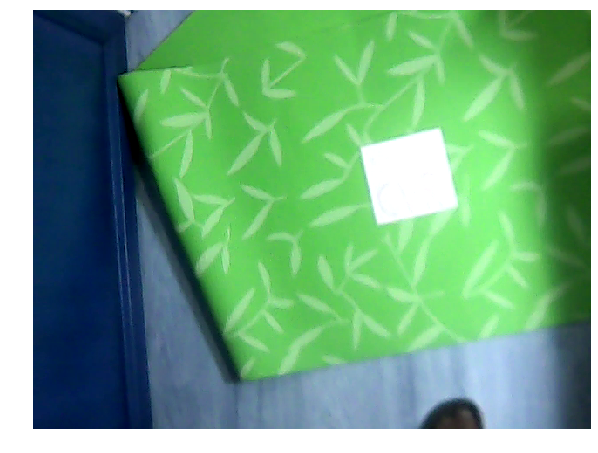

In [158]:
import numpy as np
import cv2
import time
import os
import math
import sys
from matplotlib import pyplot as plt
plt.rcParams["figure.figsize"] = (10,10)

#img = cv2.imread ("../data/images/unwarped.png", cv2.IMREAD_COLOR)
img = cv2.imread('../data/images/perimeter/vlcsnap-2020-10-21-01h21m37s326.png')

plt.imshow (img)
plt.axis ('off')
plt.show ()

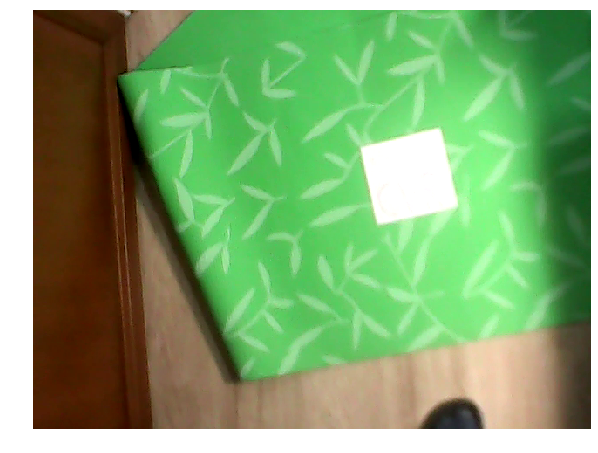

In [159]:
img_rgb = cv2.cvtColor (img, cv2.COLOR_BGR2RGB)

plt.imshow (img_rgb)
plt.axis ('off')
plt.show ()

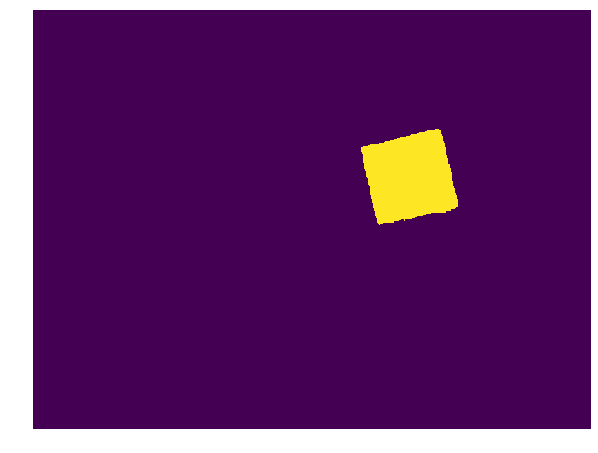

In [160]:
low_th  = (200, 200, 200)
high_th = (255, 255, 255)

mask = cv2.inRange (img, low_th, high_th)

plt.imshow (mask)
plt.axis ('off')
plt.show ()

[[[461 136]]

 [[460 137]]

 [[459 137]]

 [[458 138]]

 [[452 138]]

 [[451 139]]

 [[450 139]]

 [[449 140]]

 [[443 140]]

 [[442 141]]

 [[440 141]]

 [[439 142]]

 [[433 142]]

 [[431 144]]

 [[428 144]]

 [[427 145]]

 [[426 145]]

 [[425 146]]

 [[421 146]]

 [[420 147]]

 [[418 147]]

 [[417 148]]

 [[414 148]]

 [[413 149]]

 [[410 149]]

 [[409 150]]

 [[404 150]]

 [[402 152]]

 [[397 152]]

 [[396 153]]

 [[394 153]]

 [[393 154]]

 [[386 154]]

 [[385 155]]

 [[384 155]]

 [[383 156]]

 [[378 156]]

 [[377 157]]

 [[376 157]]

 [[376 162]]

 [[377 163]]

 [[377 164]]

 [[378 165]]

 [[378 170]]

 [[379 171]]

 [[379 174]]

 [[380 175]]

 [[380 181]]

 [[381 182]]

 [[381 184]]

 [[382 185]]

 [[382 190]]

 [[383 191]]

 [[383 192]]

 [[384 193]]

 [[384 199]]

 [[385 200]]

 [[385 201]]

 [[386 202]]

 [[386 207]]

 [[387 208]]

 [[387 211]]

 [[388 212]]

 [[388 216]]

 [[389 217]]

 [[389 220]]

 [[390 221]]

 [[390 226]]

 [[391 227]]

 [[391 229]]

 [[392 230]]

 [[392

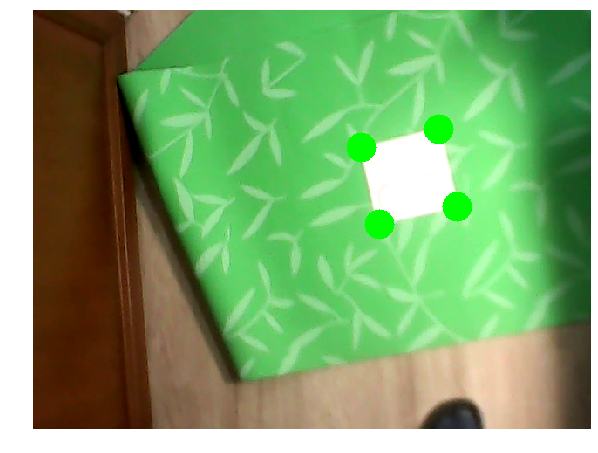

In [161]:
#contour extraction
contours, hierarchy = cv2.findContours (mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnt = contours [0]

approx = cv2.convexHull (cnt)

print (cnt)

epsilon = 0.05 * cv2.arcLength (approx, True)
#epsilon=10

approx = cv2.approxPolyDP (approx, epsilon, True)

contour_marked = cv2.drawContours (img_rgb, approx, -1, (0, 255, 0), 33)

plt.imshow (contour_marked)
plt.axis ('off')
plt.show ()

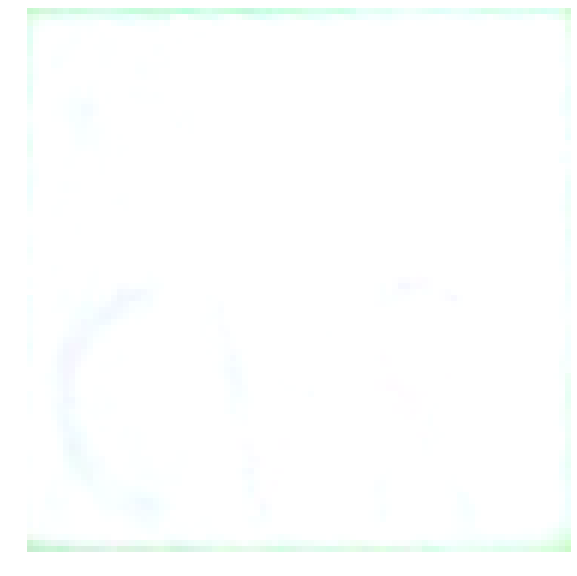

In [162]:
def order_points(pts):
    #print ("pts", pts.shape)
    
    # initialzie a list of coordinates that will be ordered
    # such that the first entry in the list is the top-left,
    # the second entry is the top-right, the third is the
    # bottom-right, and the fourth is the bottom-left
    rect = np.zeros((4, 2), dtype="float32")
    # the top-left point will have the smallest sum, whereas
    # the bottom-right point will have the largest sum
    s = pts.sum(axis=1)
    rect[0] = pts[np.argmin(s)]
    rect[2] = pts[np.argmax(s)]
    # now, compute the difference between the points, the
    # top-right point will have the smallest difference,
    # whereas the bottom-left will have the largest difference
    diff = np.diff(pts, axis=1)
    rect[1] = pts[np.argmin(diff)]
    rect[3] = pts[np.argmax(diff)]
    # return the ordered coordinates
    return rect

def four_point_transform(image, pts):
    # obtain a consistent order of the points and unpack them
    # individually
    rect = order_points(pts)
    (tl, tr, br, bl) = rect
    
    # compute the width of the new image, which will be the
    # maximum distance between bottom-right and bottom-left
    # x-coordiates or the top-right and top-left x-coordinates
    widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
    widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
    maxWidth = max(int(widthA), int(widthB))
    
    # compute the height of the new image, which will be the
    # maximum distance between the top-right and bottom-right
    # y-coordinates or the top-left and bottom-left y-coordinates
    heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
    heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
    maxHeight = max(int(heightA), int(heightB))
    
    # now that we have the dimensions of the new image, construct
    # the set of destination points to obtain a "birds eye view",
    # (i.e. top-down view) of the image, again specifying points
    # in the top-left, top-right, bottom-right, and bottom-left
    # order
    dst = np.array([
        [0, 0],
        [maxWidth - 1, 0],
        [maxWidth - 1, maxHeight - 1],
        [0, maxHeight - 1]], dtype="float32")
    
    # compute the perspective transform matrix and then apply it
    M = cv2.getPerspectiveTransform(rect, dst)
    warped = cv2.warpPerspective(image, M, (maxWidth, maxHeight))
    
    # return the warped image
    return warped

warped = four_point_transform (img, np.asarray (approx) [:, 0, :])

plt.imshow (warped)
plt.axis ('off')
plt.show ()

In [5]:
import numpy as np
import cv2
import glob
from matplotlib import pyplot as plt
plt.rcParams["figure.figsize"] = (10,10)

# termination criteria
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*7,3), np.float32)
objp[:,:2] = np.mgrid[0:7,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d point in real world space
imgpoints = [] # 2d points in image plane.

images = glob.glob('../data/images/chessboard/*.jpg')

for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chess board corners
    ret, corners = cv2.findChessboardCorners(gray, (7,6),None)

    # If found, add object points, image points (after refining them)
    if ret == True:
        objpoints.append(objp)

        corners2 = cv2.cornerSubPix(gray,corners,(11,11),(-1,-1),criteria)
        imgpoints.append(corners2)

        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (7,6), corners2,ret)
        cv2.imshow('img',img)
        cv2.waitKey(500)

cv2.destroyAllWindows()

In [6]:
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1],None,None)

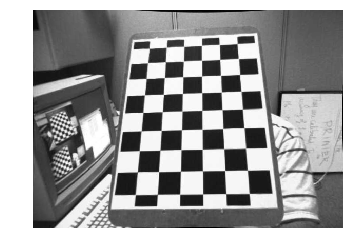

In [7]:
img = cv2.imread('../data/images/chessboard/left12.jpg')
h,  w = img.shape[:2]
newcameramtx, roi=cv2.getOptimalNewCameraMatrix(mtx,dist,(w,h),1,(w,h))

# undistort
dst = cv2.undistort(img, mtx, dist, None, newcameramtx)

# crop the image
x,y,w,h = roi
dst = dst[y:y+h, x:x+w]
#cv2.imwrite('calibresult.png',dst)

plt.imshow (dst)
plt.axis ('off')
plt.show ()



In [8]:
mtx

array([[534.21305012,   0.        , 341.94076135],
       [  0.        , 534.34222631, 234.20697573],
       [  0.        ,   0.        ,   1.        ]])

In [164]:
import numpy as np
import cv2
import time
import os
import math
import sys
from matplotlib import pyplot as plt
plt.rcParams["figure.figsize"] = (10,10)

def find_contour (img, low_th, high_th):
    img_rgb = cv2.cvtColor (img, cv2.COLOR_BGR2RGB)
    
    mask = cv2.inRange (img, low_th, high_th)
    
    contours, hierarchy = cv2.findContours (mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    cnt = contours [0]

    approx = cv2.convexHull (cnt)

    epsilon = 0.05 * cv2.arcLength (approx, True)
    approx = cv2.approxPolyDP (approx, epsilon, True)

    return approx

In [175]:
def find_distance (img):
    low_th  = (200, 200, 200)
    high_th = (255, 255, 255)

    contour = find_contour (img, low_th, high_th)
    
    length = cv2.arcLength (contour, True)
    
    print (contour)

    distance = 180.0 * 364 / length
    
    return distance

In [179]:
#img = cv2.imread('../data/images/perimeter/vlcsnap-2020-10-21-01h21m37s326.png')
#img = cv2.imread('../data/images/perimeter/vlcsnap-2020-10-21-01h21m44s087.png')
#img = cv2.imread('../data/images/perimeter/vlcsnap-2020-10-21-01h21m50s155.png')
img = cv2.imread('../data/images/perimeter/vlcsnap-2020-10-21-01h21m55s352.png')

dist = find_distance (img)

print (dist)

[[[499 286]]

 [[293 356]]

 [[220 159]]

 [[424  82]]]
75.91619704490874


Возьмите видео https://drive.google.com/file/d/1AQhg2lL5FL4edlOcxY2SHOOZ-v9TgHBD/view?usp=sharing и реализуйте ноутбук, выполняющий сделующие операции для каждого кадра видео:

1) [2 балла] Нахождение расстояния от камеры до листка, учитывая, что это тот же листок, что был в первом демо

2) [3 балла] Приведение изображения листка к "виду сверху"

3) [6 баллов] Определение направления, в котором указывает стрелка. Для выполнения этого пункта можно совместить результат предыдушего пункта с переработанным методом из первого семинара по зрению. Можно использовать и полностью свой метод

4) [6 баллов] Доп. задача: определение, нормально ли видно листок в кадре. На некоторых кадрах листок видно не полностью. Это можно автоматически обнаруживать, к примеру используя размеры стрелки, и выводить на соответствующем кадре маркер - текст или цветную метку